# Intro to Dask with Array

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Array
- Create Date: 2021-May
- Lineage/Reference: This tutorial is referenced to [dask-tutorial](https://github.com/dask/dask-tutorial)
----


`Dask` is a parallel computing library that enables you to scale your python workflows and execute computations on at scale on different architectures.

`Dask` can scale down to your laptop and up to a cluster, supercomputing center, remote workstation or cloud provider, giving you enormous flexibility in the compute backend you provide your workflow.

We are going to cover an intro to `Dask` in this workbook and begin to scale up from there!

We will start with `Dask` arrays as many people will already be familiar with `NumPy`' arrays and these will form an easy intro to `Dask` functionality

In [1]:
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

One of the critical concepts of `Dask` is that your tasks can be excecuted by any arbitrary **backend engine** called a `Client`. 

Here we are going to start a client using the defualt configuration, which makes an asessment of available resources and automatically sorts out a `Client`.

For example on my laptop my client has 4 processes, 4 threads and 8Gb of memory. 


In [2]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)
print(client.dashboard_link)

<Client: 'tcp://127.0.0.1:45831' processes=4 threads=4, memory=15.00 GiB>
/proxy/8787/status


Importantly I have shown something called the client `dashboard_link`.  The dashboard shows all kinds information related to workers, computation, performance, tasks to be executed, memory saturation and so on and so forth.  I highly reccomend that you split your screen and look at the dashboard in tandem with the below section.

# Dask Arrays

A dask array looks and feels a lot like a numpy array. However, a dask array doesn't directly hold any data. Instead, it symbolically represents the computations needed to generate the data. Nothing is actually computed until the numerical values are needed. This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over to the scheduler for execution.

This is very powerful as it allows us to build a complex task graph that can be executed by a number of parallel backends.

As an example, lets make a numpy array of `ones` of shape `1000,4000` and use `Dask` syntax to break it into 4 chunks of `1000,1000`.  

In [24]:
shape = (1000, 4000)
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)

print(type(ones))
ones

<class 'dask.array.core.Array'>


dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

**Note also that no computation has been performed at this stage!** We merely have a symbolic evaluation of our task to be performed.

Note also that our "result " is a dask array, a dask wrapper around a numpy.ndarray with all kinds of helpful goodies. 

What if we want our actual results?

In [4]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Using the `.compute()` method we can force the execution of our task graph.

Another super handy method is to visualise how our task graph was executed using the `da.dask` attribute and  `da.visualize()` method.

In [5]:
ones.dask


HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x150036c96460>
 0. ones_like-dc1a3bb5299721be961777e6cb7679b1

the '.dask' attribute gives us all kinds of info about out task graph, how it was executed and the size, type and dimensions of data. 

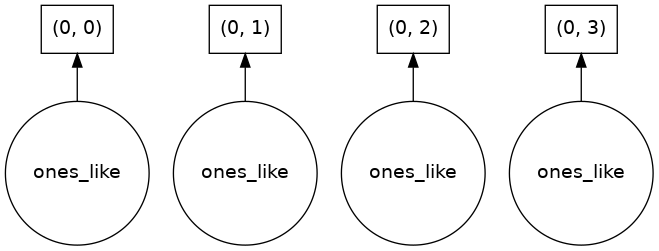

In [6]:
ones.visualize()

.visualise() gives us a more visual representation of the above, showing execution of 4 ones-like operations to tile out our `1000 x 4000 `matrix using four chunks of shape `1000, 1000`. 

Lets do something a little more complicated and perform a reduction on our matrix:

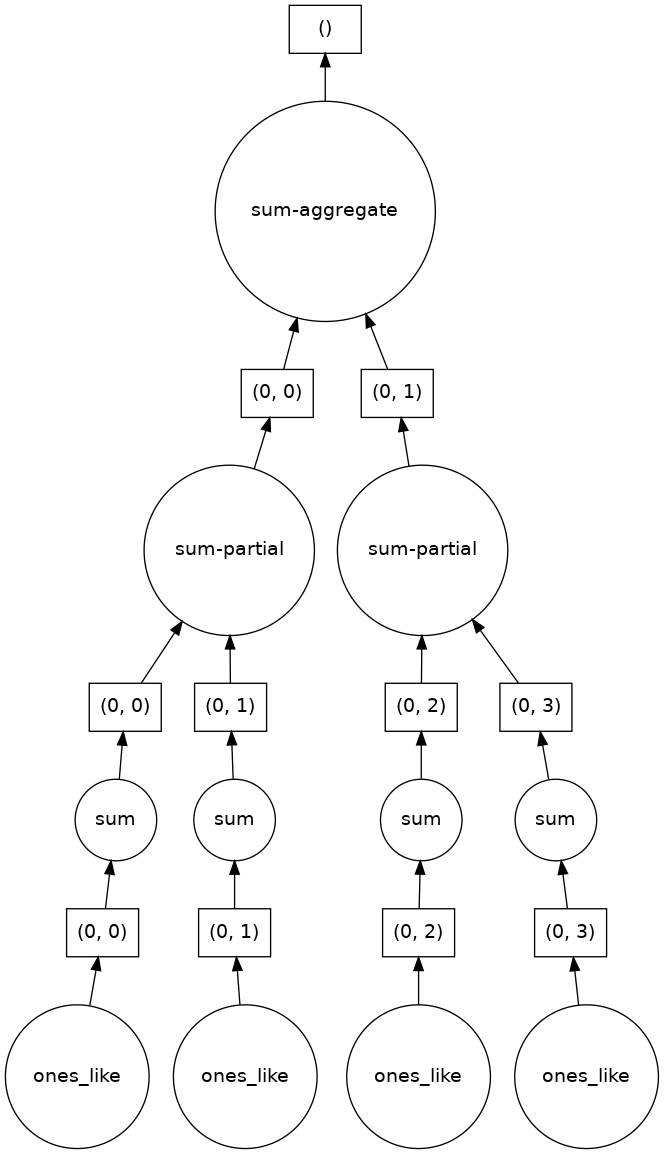

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data, in this case doing partial sums and aggregating based on the number of workers and available memory.

If we make our operation more complex in this case computing:


$ result =  mean(x (x^2+2)) $ 


the graph gets more complex.

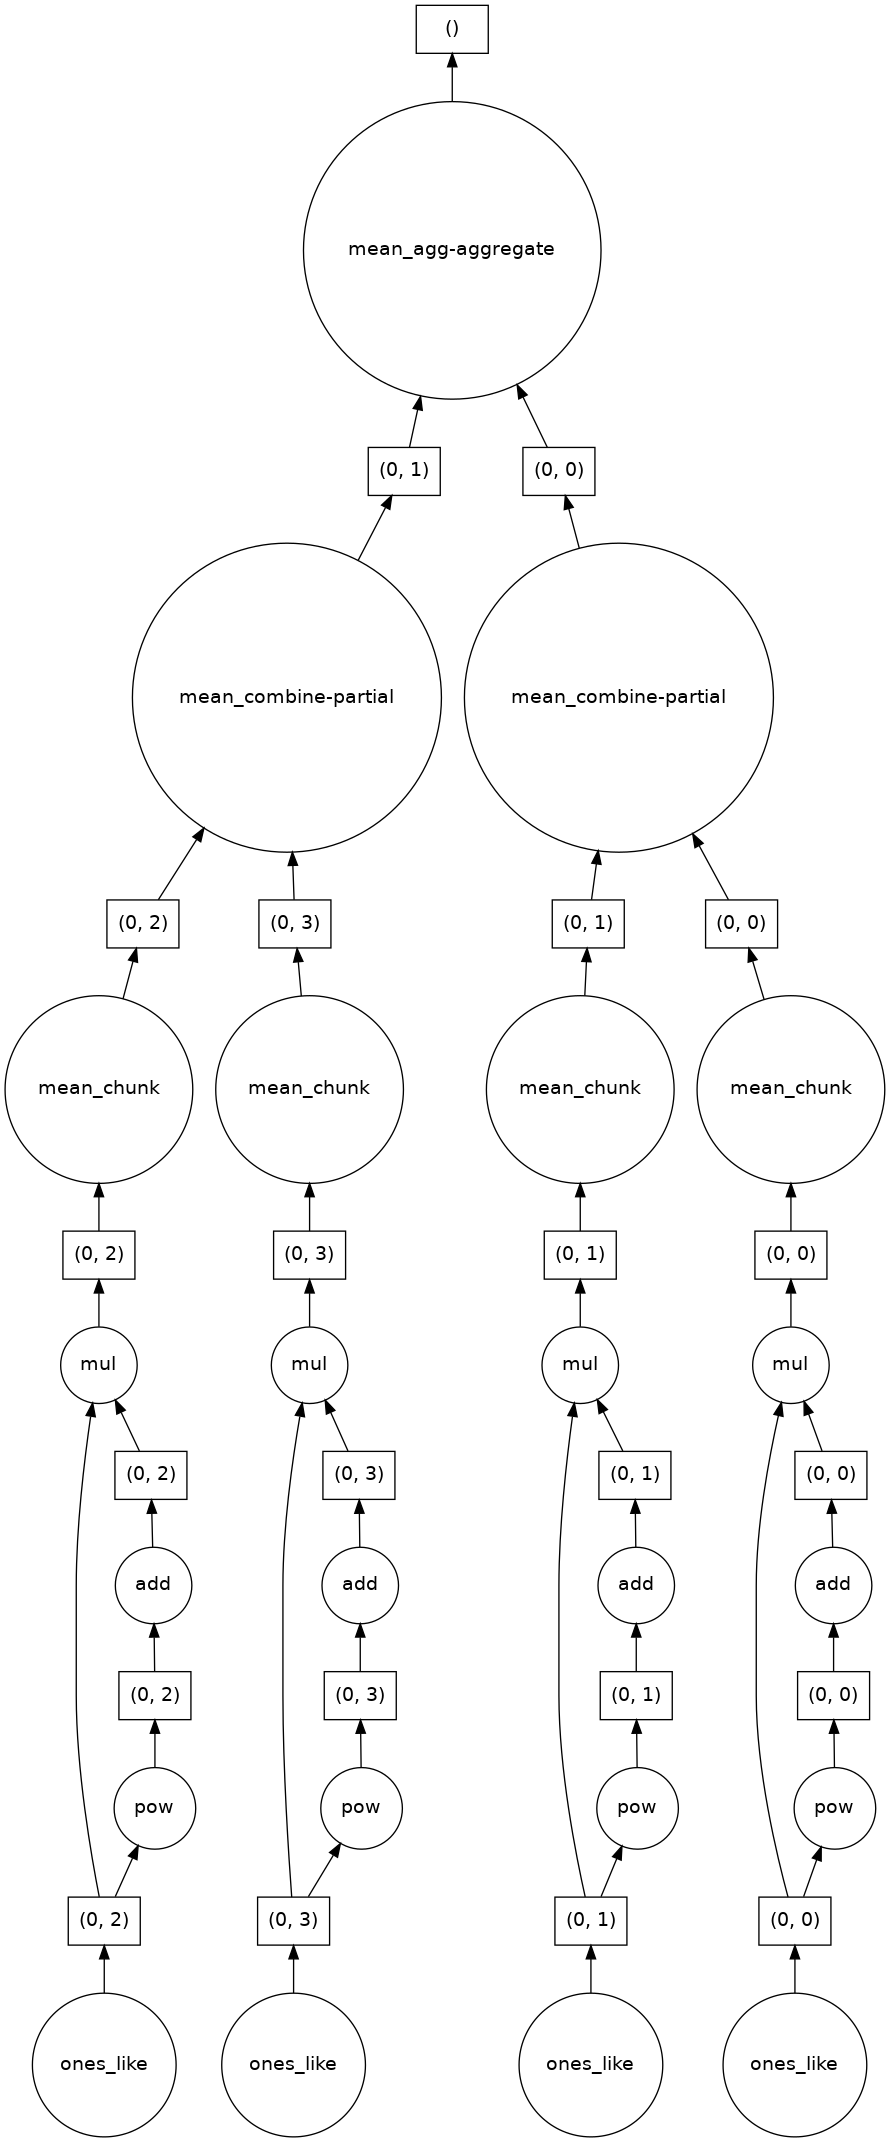

In [8]:
fancy_calculation = (ones * (ones**2 + 2)).mean()
fancy_calculation.visualize()


In [9]:
fancy_calculation.compute()

3.0

That was easy, remembering that:

$ mean(1 (1^2+2)) = 3$ 

## Challenge

Make an array of `20000x20000` array of random numbers using `da.random.random` and compute the sum of their cubes using dask.

$result = sum(x^3)$

Visualize the computation as part of your workflow.



In [10]:
# compute your  result here 

# hint to get the random array use 

#random = da.random.random(size=...)

<details><summary><b>Solution</b></summary>
   <pre>
    <br>random = da.random.random(size=(20000,20000))
    result = (random**3).sum()
    result.visualize()
    result.compute()
   </pre>
</details>

Lets do something a little more complicated and larger, that can also show us that `Dask` functionality works with `numpy` out of the box.

First lets sample 20000 points from 4000 normal distributions centered on 0.

In [11]:
# sample from 4k normal distributions
bigshape = (4000, 20000)
random_normal = da.random.normal(size=bigshape, chunks=chunk_shape)
random_normal


dask.array<normal, shape=(4000, 20000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Lets add an offset to each normal distirbution which are themselves normal. In other words for each normal distribution we shift the mean by a random amount. 

In [12]:
# lets add a random offset to each normal distribution, which are themselves normal.

offsets = da.random.normal(size=(bigshape[0], 1))
print(offsets)
intermediate = offsets + random_normal

# we now have a set of normal distributions modified by normally distributed noise

dask.array<normal, shape=(4000, 1), dtype=float64, chunksize=(4000, 1), chunktype=numpy.ndarray>


Now we perform a reduction by finding the means along the **sampling axis** i.e the 20,000 points we drew. 

In [13]:
# reduce by finding their means, resulting in a normal distribution
result = intermediate.mean(axis=1)
result

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

Lets have a look at the taks graph.

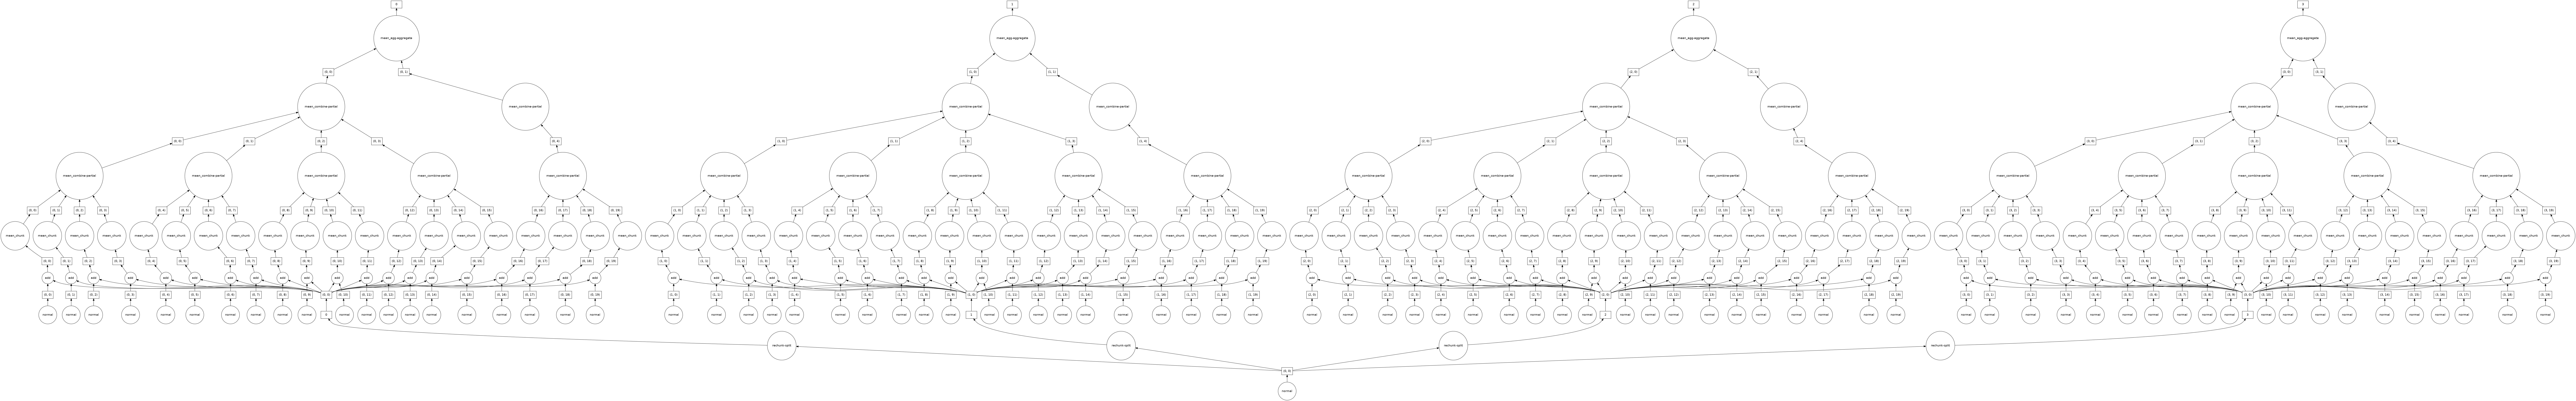

In [14]:
# have a look at the task graph
result.visualize()

Finally lets compute our result and calculate some descriptive statistics.

If you can have a look at your dashboard while executing this cell

In [15]:
final = result.compute()
mean = np.mean(final)
std = np.std(final)

In [16]:
print(mean)
print(std)

-0.0006532691213778338
0.9888494270093239


It turns out our mean is ~0 and our standard deviation is ~1. This means we have recovered a normal distribution. I won't go into the maths behind this but lets verify by plotting a histogram. 

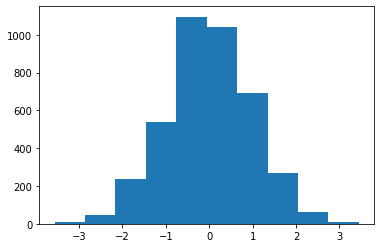

In [17]:
# verify normal distirbution
plt.hist(final)
plt.show()

That looks pretty normal to me!

We can reuse our task graph with an extra step and also use numpy functions directly in our dask operations.

Lets compute the `cosine` of our resulting normal distribution.

In [18]:
cos_result = np.cos(result)
cos_result

dask.array<cos, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [19]:
cos_result.dask

HighLevelGraph with 9 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x150020c9a910>
 0. normal-561781b628fd6bfb0dc16ca20255ada8
 1. normal-77b4b37defa161fc503cba32e6e40120
 2. rechunk-merge-275a8ec9c027c6fda03df1746a661c69
 3. add-4a467ba29eea6e81888fc5d32cdbc954
 4. mean_chunk-30f6d8e47cadcd5328ef39fcd16a2b2b
 5. mean_combine-partial-ea41c5136714c46b2c067cae57e64db4
 6. mean_combine-partial-058d13846136faeae2c7e405468f8814
 7. mean_agg-aggregate-5626ebb4888d27cc603cebc2d75ce16e
 8. cos-c20a090d077c277d99725d551fcd2271

Note that the above is a **task graph and not a result**, meaning we have to call compute again.

Have a detailed look at the above diagram and notice which blocks are coloured grey and white. What is the difference between their attributes? Have a paticular look at the `is_materialized` field. What do you think that means?

## Challenge

What does the `is_materialized` field mean, explain in your own words in a Markdown cell below.

The is_materialized field indicates ....

In [20]:
# we compute our result
cos_final = cos_result.compute()
cos_final

array([0.03797625, 0.8105601 , 0.69132909, ..., 0.25962437, 0.45643464,
       0.04691846])

because we recovered a normal distribution through our reduction where values are normally distributed around zero and:

$ cos(0) = 1$

our the majority of our cos_final results will be close to one. Lets confirm this graphically.

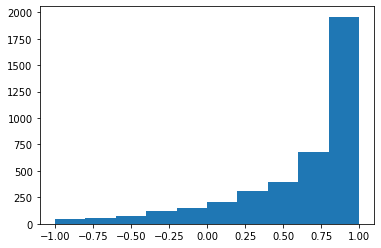

In [21]:
plt.hist(cos_final) 
plt.show()

## Challenge

Follow the same workflow but this time plot the `sin()` of our normal distribution, where do the majority of the values lie?

In [22]:
# plot the sin of our normal distribution and make a histogram of its resulting distribution



## Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [23]:
client.close()

## Conclusion

Hopefully this basic intro has given you the tools to work `Dask` arrays for parallel computation. 

**Jump over to [Notebook 2](./dask_delayed_02.ipynb) now.** 